<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Regresión Linear - Ejemplo </h1>
<h3> Análisis y Visualización de Datos - 2019 </h3>

En este ejemplo veremos cómo implementar una regresión logística para predecir una variable numérica. Volveremos a utilizar el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato.

Usaremos la misma versión del conjunto de datos que en el práctico.

En esta notebook vamos a tratar de estimar una función lineal que modele el cambio a través del tiempo de la libertad personal y la económica.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
seaborn.set_context(context='talk', font_scale=1.2)

In [0]:
BLUE = '#35A7FF'
RED = '#FF5964'
GREEN = '#6BF178'
YELLOW = '#FFE74C'

In [0]:
dataset = pandas.read_csv(
    'https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2019.csv')
dataset.shape

(1620, 120)

In [0]:
score_cols = [col for col in dataset.columns if 'pf_identity' in col] + [
    'pf_score', # Personal Freedom (score)
    'pf_rank', # Personal Freedom (rank)
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

important_cols = ['year', 'ISO_code', 'countries', 'region'] + score_cols

In [0]:
dataset = dataset[important_cols].replace('-', numpy.nan)
for score_col in score_cols:
    dataset[score_col] = pandas.to_numeric(dataset[score_col])
dataset

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.29,7.0,8.18,6.0,8.73,4.0
1616,2008,DNK,Denmark,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.49,3.0,7.98,9.0,8.73,4.0
1617,2008,CHE,Switzerland,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.31,6.0,8.35,4.0,8.83,3.0
1618,2008,NZL,New Zealand,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.42,4.0,8.46,3.0,8.94,2.0


En el práctico habíamos trabajado sobre las variables `ef_score` y `pf_score`, que hacen referencia a los índices de libertad personal y libertad económica de cada páis. Además, sabemos que el dataset incluye una medición del índice anual por país desde 2008 hasta 2016, aunque hay datos faltantes de algunos indicadores.

La motivación de este análisis comienza con este gráfico, que muestra una tendencia decreciente de la libertad personal y una tendencia ascendiente de la libertad económica. La libertad humana o `pf_score` es el promedio de ambos indicadores

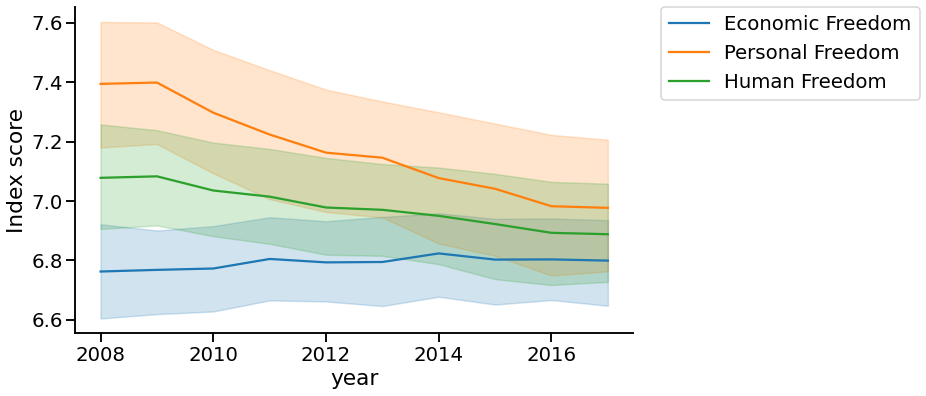

In [0]:
plt.figure(figsize=(10,6))
seaborn.lineplot(data=dataset,
                 x='year', y='ef_score',
                 label='Economic Freedom')
seaborn.lineplot(data=dataset,
                 x='year', y='pf_score',
                 label='Personal Freedom')

seaborn.lineplot(data=dataset,
                 x='year', y='hf_score',
                 label='Human Freedom')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Index score')
seaborn.despine()

Este fenómeno podría estar dado por varios factores:
  * Hay pocos países en los que la libertad personal está decreciendo, pero su libertad económica se mantiene constante.
  * Los países para los cuales sube la libertad económica decrecen en libertad personal.
  * **¿Otras?**

Veamos qué sucede en Argentina. Si graficamos ambas variables, vemos que "van bajando". Formalmente, esto significa que hay la recta que las modela tiene una pendiente negativa.

**¿Y esto, es grave?**

(2008.0, 2016.0)

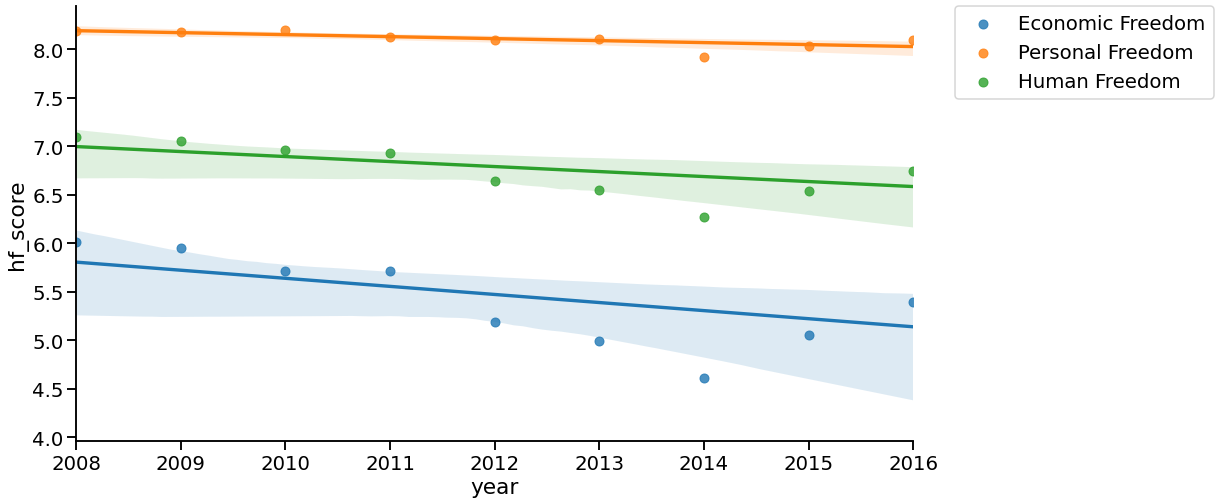

In [0]:
plt.figure(figsize=(15, 8))
seaborn.regplot(data=dataset[(dataset.ISO_code == 'ARG')],
                    x='year', y='ef_score', label='Economic Freedom')
seaborn.regplot(data=dataset[(dataset.ISO_code == 'ARG')],
                    x='year', y='pf_score', label='Personal Freedom')
seaborn.regplot(data=dataset[(dataset.ISO_code == 'ARG')],
                    x='year', y='hf_score', label='Human Freedom')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine()
plt.xlim(2008, 2016)

Podemos graficar varios países, pero es difícil comparar visualmente entre tantas variables, qué países "decrecen" más rápido que otros.

Puntajes de libertad para América Latina


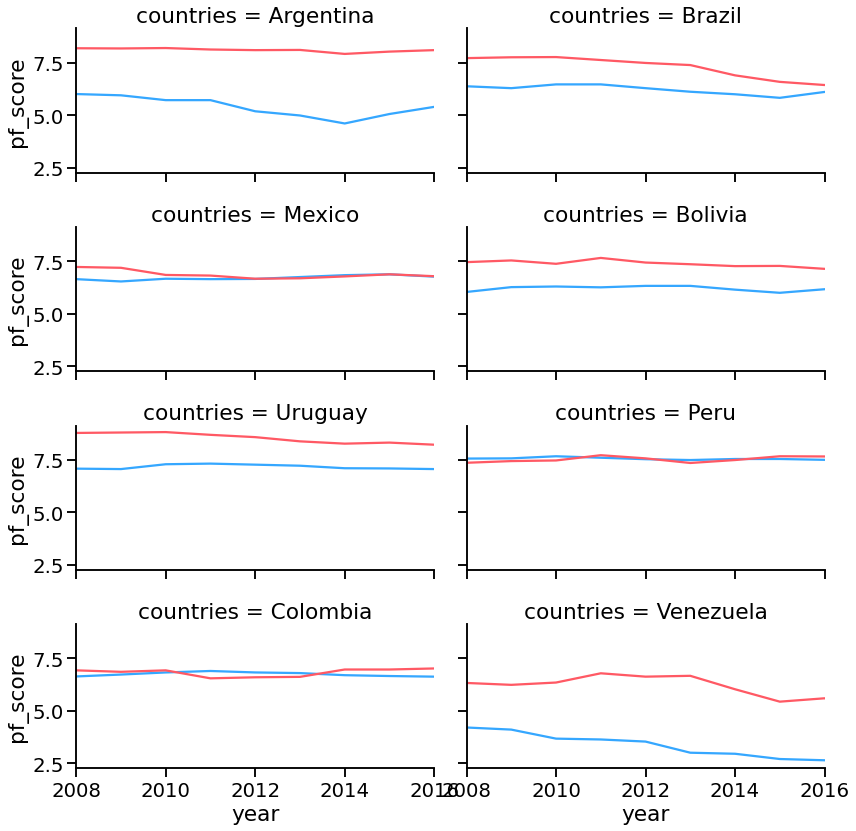

In [0]:
countries = ['Argentina', 'Brazil', 'Mexico', 'Bolivia',
             'Uruguay', 'Peru', 'Colombia', 'Venezuela']
g = seaborn.FacetGrid(dataset, col="countries",
                      margin_titles=True, aspect=2, col_wrap=2,
                      col_order=countries)
g.map(seaborn.lineplot, "year", "ef_score", color=BLUE)
g.map(seaborn.lineplot, "year", "pf_score", color=RED)
g.set(xlim=(2008, 2016))

print('Puntajes de libertad para América Latina');

Para poder comparar la situación de Argentina con otros países, podemos comparar la pendiente de la recta de la regresión lineal. A partir del gráfico anterior pudimos ver que la mayoría de los países tiene tendencias similares y que se pueden estimar con una recta sin perder generalidad. Esto es posible también, en cierta medida, porque tenemos pocos puntos para estimar.

## Regresión lineal

Queremos ver cuál es el coeficiente que relaciona ambas variables.


Primero: **¿Cuál es la variable dependiente? ¿Cuál la independiente?**

Una vez que hemos determinado eso, lo que queremos encontrar es la función de la siguiente forma:

$$ef = a * year + b$$

Reescribiremos esto como una función $e$ (por economic), cuyo parámetro es el valor $y$ (por year):

$$e(y) = a * y + b$$

Vamos a describir los ejemplos como pares $(x_y, x_e)$, donde $x_y$ denota el `year` y $x_e$ denota `ef_score`. 

Para encontrar la recta $e$ que mejor describe los datos, queremos minimizar el error cuadrático medio, definido como:

$$mse = \frac{1}{|X|} \sum_{x \in X} (e(x_y) - x_e)^2 $$

Recordemos que para minimizar una función, una buena opción es comenzar por buscar los puntos estacionarios, donde la derivada se anula. Por suerte, la función $mse$ es convexa, y por lo tanto tiene todos sus puntos estacionarios son minimizadores. El minimizador es el valor de los parámetros $a$ y $b$ que minimizan la función. Ahora, en hemos cambiado nuestras "variables", lo que buscamos es encontrar la función adecuada, por lo tanto lo que cambia son los valores de los parámetros que definen la función. 

Primero, notemos que:

$$\frac{\partial}{\partial a}e(y) = x_p$$

$$\frac{\partial}{\partial b}e(y) = 1$$

Con eso, calculamos las derivadas parciales para cada parámetro de la función $mse$.

$$\frac{\partial}{\partial a}mse = \frac{2}{|X|} \sum_{x \in X} (e(x_p) - x_e) \frac{\partial}{\partial a} (e(x_p) - x_e) = \frac{2}{|X|} \sum_{x \in X} (e(x_p) - x_e) e_p $$

$$\frac{\partial}{\partial b}mse = \frac{2}{|X|} \sum_{x \in X} \frac{\partial}{\partial b} e(x_p) - x_e = \frac{2}{|X|} \sum_{x \in X} e(x_p) - x_e $$


A pesar del formulerío, es bastante simple. Sólo reemplazamos $mse$ por su definición, y luego aplicamos un par de reglas como "la derivada de la suma es la suma de las derivadas", la regla de la cadena, o la definición de la derivada de la función cuadrática.

Una vez que tenemos esos valores, tenemos que igualarlos a cero para encontrar los puntos estacionarios.

\begin{align}
 \frac{\partial}{\partial a}mse &= \frac{2}{|X|} \sum_{x \in X} (e(x_y) - x_e) x_y = 0 \\
                                &\Rightarrow a = \frac{\bar{x_y} \bar{x_e} - \overline{x_yx_e}}{(\bar{x_y})^2 - \overline{x_y^2}} 
\end{align}

\begin{align}
 \frac{\partial}{\partial b}mse &= \frac{2}{|X|} \sum_{x \in X} e(x_y) - x_e = 0 \\
                                &\Rightarrow b = \bar{x_e} - a \bar{x_y}
\end{align}

Donde $\bar{x}$ es la media del valor para todos los ejemplos. Vamos a confiar en estas fórmulas, pero una demostración de las mismas está en:

https://medium.freecodecamp.org/machine-learning-mean-squared-error-regression-line-c7dde9a26b93

In [0]:
def estimate_params(X_y, X_e):
    """Caculates the value of a using all the examples."""
    num = numpy.mean(X_y)*numpy.mean(X_e) - numpy.mean(numpy.multiply(X_y, X_e))
    denom = numpy.mean(X_y)**2 - numpy.mean(numpy.multiply(X_y, X_y))
    a = num / denom
    b = numpy.mean(X_e) - a * numpy.mean(X_y)
    return a, b

In [0]:
# Asumimos que todos los registros que tienen pf_score tienen el año.
a, b = estimate_params(
    dataset[(dataset.ISO_code == 'ARG') &
            (dataset.pf_score.notnull())].year.dropna(),
    dataset[dataset.ISO_code == 'ARG'].pf_score)
a, b

(-0.02048484848483261, 49.32575757572563)

In [0]:
def base_linear_regression(x_y, a):
    return a * x_y

In [0]:
def regplot2(data, x, y, reg_func, **reg_func_args):
    """Plots the x, y columns from data and builds a
    line with the regression reg_func."""
    seaborn.scatterplot(data=data, x=x, y=y, color=BLUE)
    minimum = data[x].min()
    maximum = data[x].max()
    plt.plot([minimum, maximum],
             [reg_func(minimum, **reg_func_args),
              reg_func(maximum, **reg_func_args)],
             color=GREEN)
    seaborn.despine()
    plt.show()

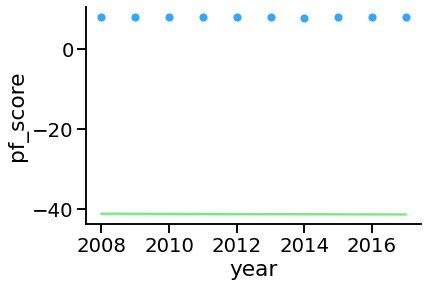

In [0]:
regplot2(dataset[dataset.ISO_code == 'ARG'],
         x='year', y='pf_score', reg_func=base_linear_regression,
         a=a)

Vemos que la recta va en el sentido correcto, pero está demasiado abajo. Esto ocurre porque no hemos usado el término de bias.

Redefinamos entonces la regresión logística

In [0]:
def linear_regression(x_y, a, b):
    return a * x_y + b

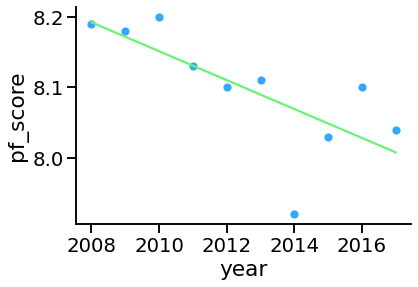

In [0]:
regplot2(dataset[dataset.ISO_code == 'ARG'],
         x='year', y='pf_score', reg_func=linear_regression,
         a=a, b=b)

## Continuamos el análisis

Perfecto! Ahora podemos calcular las pendientes y los biases para todos los años, para regresiones que estimen el `pf_score`.

In [0]:
def build_regressions(data, x_var='year', y_var='pf_score'):
    records = []
    for code in data.ISO_code.unique():
        record = [code, data[data.ISO_code == code].region.values[0],
                  data[data.ISO_code == code].countries.values[0]]
        y_data = data[data.ISO_code == code][y_var].dropna()
        # Comprobamos que hay datos en el intervalo
        if len(y_data) <= 1:
            continue
        x_data = data[(data.ISO_code == code) &
                      (data[y_var].notnull())][x_var].dropna()
        # Estimamos los parámetros
        a, b = estimate_params(x_data, y_data)
        # Calculamos el error cuadrático medio de la regresión lineal estimada
        predictions = numpy.apply_along_axis(
            lambda x: linear_regression(x, a, b), 0, x_data)
        mse = numpy.mean(numpy.power(predictions - y_data, 2))
        record.extend([a, b, mse])
        # Agregamos el registro
        records.append(record)
    return pandas.DataFrame.from_records(
        records, columns=['ISO_code', 'region', 'country',
                          'slope', 'bias', 'mse']
    )

In [0]:
pf_regressions = build_regressions(dataset).set_index('ISO_code')
pf_regressions[:10]

,region,country,slope,bias,mse
ISO_code,,,,,
ALB,Eastern Europe,Albania,-0.036909,82.084545,0.044086
DZA,Middle East & North Africa,Algeria,-0.006121,17.587939,0.009140
AGO,Sub-Saharan Africa,Angola,0.087636,-170.678182,0.039059
ARG,Latin America & the Caribbean,Argentina,-0.020485,49.325758,0.003178
ARM,Caucasus & Central Asia,Armenia,-0.016667,40.756667,0.008773
AUS,Oceania,Australia,-0.011576,32.513212,0.002516
AUT,Western Europe,Austria,0.037394,-66.048303,0.007005
AZE,Caucasus & Central Asia,Azerbaijan,-0.105758,218.958121,0.060136
BHS,Latin America & the Caribbean,Bahamas,-0.032909,74.170545,0.009934


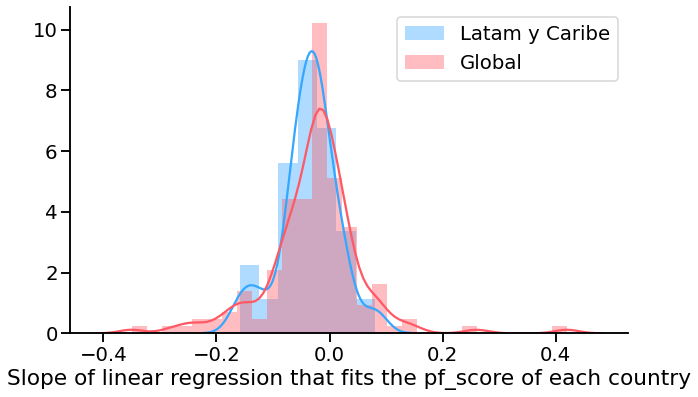

In [0]:
plt.figure(figsize=(10,6))
seaborn.distplot(
    pf_regressions[pf_regressions.region == 'Latin America & the Caribbean'].slope,
    color=BLUE, label='Latam y Caribe')
seaborn.distplot(pf_regressions.slope, color=RED, label='Global')
plt.xlabel('Slope of linear regression that fits the pf_score of each country')
plt.legend()
seaborn.despine()

In [0]:
def plot_regressions(regressions):
    plt.figure(figsize=(10,6))
    colors = seaborn.color_palette("cubehelix", len(regressions))
    for color, (year, row) in zip(colors, regressions.iterrows()):
        minimum, maximum = 2008, 2016
        plt.plot([minimum, maximum],
                 [linear_regression(minimum, row['slope'], row['bias']),
                  linear_regression(maximum, row['slope'], row['bias'])],
                 color=color, label=str(year), linestyle='--')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    seaborn.despine()

(4.0, 10.0)

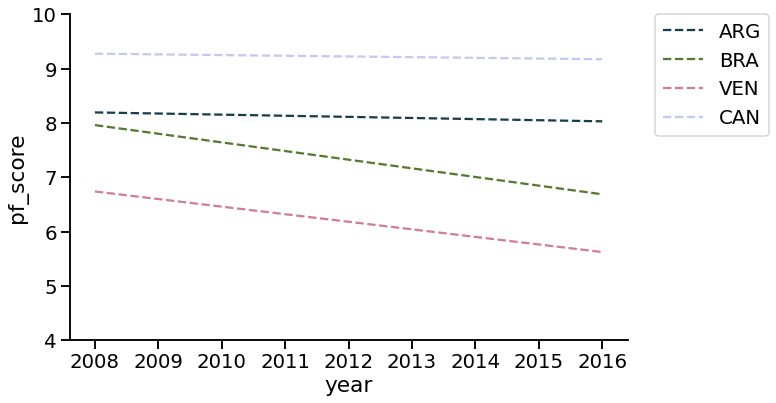

In [0]:
plot_regressions(pf_regressions.loc[['ARG', 'BRA', 'VEN', 'CAN']])
plt.xlabel('year')
plt.ylabel('pf_score')
plt.ylim(4, 10)

### Libertad Económica

In [0]:
ef_regressions = build_regressions(dataset, y_var='ef_score').set_index('ISO_code')
ef_regressions[:10]

,region,country,slope,bias,mse
ISO_code,,,,,
ALB,Eastern Europe,Albania,0.047333,-87.801333,0.003397
DZA,Middle East & North Africa,Algeria,-0.042606,90.805697,0.009553
AGO,Sub-Saharan Africa,Angola,0.015394,-25.786303,0.084069
ARG,Latin America & the Caribbean,Argentina,-0.083273,173.018364,0.132188
ARM,Caucasus & Central Asia,Armenia,0.013333,-19.165333,0.003609
AUS,Oceania,Australia,-0.010909,30.026545,0.002294
AUT,Western Europe,Austria,-0.008485,24.819758,0.000690
AZE,Caucasus & Central Asia,Azerbaijan,0.042242,-78.787879,0.007204
BHS,Latin America & the Caribbean,Bahamas,-0.026667,61.038667,0.003569


Text(0, 0.5, 'ef_score')

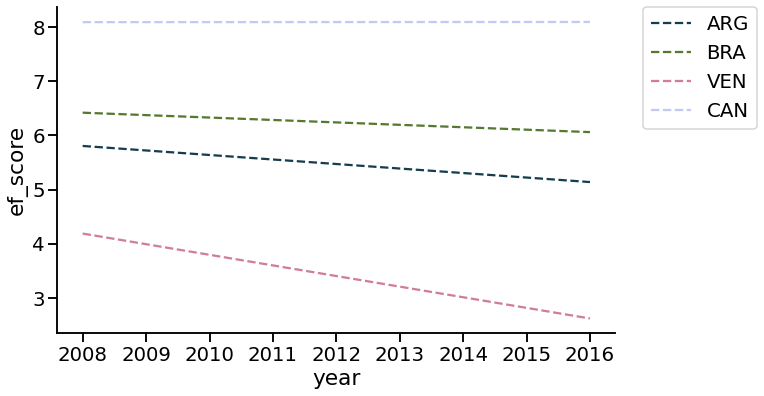

In [0]:
plot_regressions(ef_regressions.loc[['ARG', 'BRA', 'VEN', 'CAN']])
plt.xlabel('year')
plt.ylabel('ef_score')

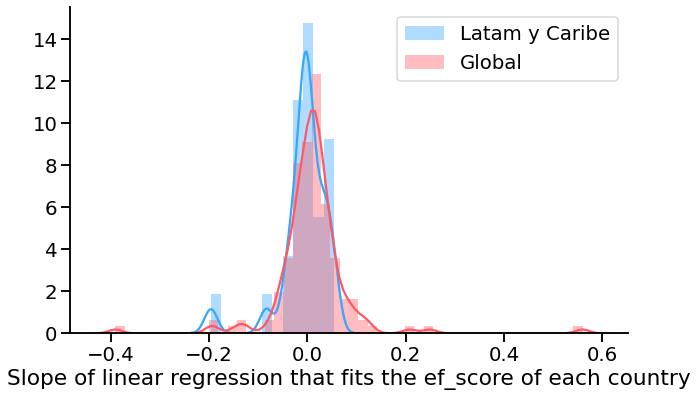

In [0]:
plt.figure(figsize=(10,6))
seaborn.distplot(
    ef_regressions[ef_regressions.region == 'Latin America & the Caribbean'].slope,
    color=BLUE, label='Latam y Caribe')
seaborn.distplot(ef_regressions.slope, color=RED, label='Global')
plt.xlabel('Slope of linear regression that fits the ef_score of each country')
plt.legend()
seaborn.despine()

## Análisis conjunto

**¿Cuáles es el 10% de países en los que la libertad humana disminuye más rápidamente?**

In [0]:
quantil = pf_regressions.slope.quantile(0.1)
pf_regressions[pf_regressions.slope < quantil].country

ISO_code
BTN               Bhutan
BRA               Brazil
BRN    Brunei Darussalam
BDI              Burundi
EGY                Egypt
GMB          Gambia, The
MUS            Mauritius
NPL                Nepal
NER                Niger
RWA               Rwanda
SYR                Syria
TJK           Tajikistan
THA             Thailand
TUR               Turkey
UKR              Ukraine
VEN            Venezuela
YEM          Yemen, Rep.
Name: country, dtype: object

**¿Cuáles es el 10% de países en los que la libertad económica disminuye más rápidamente?**

In [0]:
quantil = ef_regressions.slope.quantile(0.1)
ef_regressions[ef_regressions.slope < quantil].country

ISO_code
ARG            Argentina
BRA               Brazil
BRN    Brunei Darussalam
EGY                Egypt
FJI                 Fiji
GHA                Ghana
IRQ                 Iraq
KWT               Kuwait
LBR              Liberia
LBY                Libya
PNG      Pap. New Guinea
SLE         Sierra Leone
SDN                Sudan
SYR                Syria
TUN              Tunisia
VEN            Venezuela
ZMB               Zambia
Name: country, dtype: object

**¿Cuáles son los paises en los que la libertad económica aumenta pero la libertad personal disminuye (rápidamente)?**

In [0]:
all_countries = dataset.ISO_code.unique()
codes = []
for code in all_countries:
    if (code in ef_regressions.index and code in pf_regressions.index and
        ef_regressions.loc[code].slope > 0.02 and
        pf_regressions.loc[code].slope < -0.02):
        codes.append(code)
ef_regressions.loc[codes].country

ISO_code
ALB        Albania
AZE     Azerbaijan
BGR       Bulgaria
BDI        Burundi
KHM       Cambodia
CPV     Cape Verde
CHN          China
GMB    Gambia, The
GTM      Guatemala
GIN         Guinea
ISL        Iceland
IDN      Indonesia
KAZ     Kazakhstan
LAO           Laos
MYS       Malaysia
MLT          Malta
MEX         Mexico
MAR        Morocco
MMR        Myanmar
NPL          Nepal
NER          Niger
PRY       Paraguay
PHL    Philippines
RUS         Russia
RWA         Rwanda
ESP          Spain
TZA       Tanzania
VNM        Vietnam
Name: country, dtype: object

# Errores

Calculamos el mse pero nunca lo usamos. Veamos cómo son los países para los que la regresión linear no produce una buena aproximación

In [0]:
pf_regressions.mse.sort_values()[-10:]

ISO_code
TLS    0.106220
SYC    0.107328
TUR    0.126490
CAF    0.142989
VEN    0.145224
COD    0.165123
LBY    0.182368
GNB    0.194737
YEM    0.195064
BDI    0.206774
Name: mse, dtype: float64

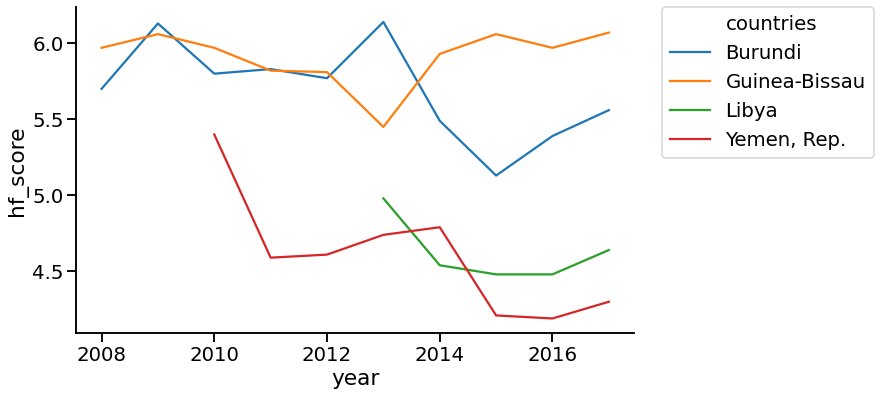

In [0]:
plt.figure(figsize=(10,6))
countries = ['BDI', 'YEM', 'GNB', 'LBY']
seaborn.lineplot(data=dataset[dataset.ISO_code.isin(countries)], x='year', y='hf_score',
                 hue='countries')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine()

Claramente se ve que estas funciones no podían ser estimadas satisfactoriamente con una recta, pero aún así, la tendencia general (descendiente o ascendiente) habría sido aproximada